# Hồi quy Gamma với tensorflow probability

### BS. Lê Ngọc Khả Nhi

# Nhập đề

Giá trị tham chiếu của xét nghiệm có ý nghĩa quan trọng trong thực hành lâm sàng. Thông thường, người bác sĩ cần đối chiếu kết quả xét nghiệm của một bệnh nhân với ngưỡng trên hoặc dưới của phân bố đại lượng đó trong quần thể người bình thường, từ đó xác định liệu kết quả của bệnh nhân có tăng hoặc giảm một cách bất thường hay không.

Các mô hình hồi quy của thống kê cổ điển đã góp phần rất lớn giúp xây dựng các khoảng giá trị tham chiếu trong y học. Người ta đã sử dụng những mô hình tuyến tính tổng quát (GLM) với phân phối Gaussian trong hàng chục năm, rồi khoảng 10 năm trước, ta biết đến mô hình GAMLSS mạnh và linh hoạt hơn. Hiện nay, ta có thêm một công cụ còn tốt hơn nữa, đó là Deep learning với probabilistic layer.


# Mục tiêu

Trong bài thực hành này, Nhi sẽ làm một thí nghiệm sử dụng keras và tensorflow probability để dựng một mô hình Deep neural network với probabilistic output layer, mô hình này xuất ra kết quả là một phân phối Gamma, từ đó cho phép ước tính ngưỡng giá trị tham chiếu cho 1 xét nghiệm sinh lý có tên là DLCO, dựa vào Tuổi, chiều cao và giới tính của bệnh nhân.

In [1]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

# Deep learning tools

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping

tfd = tfp.distributions

# Metrics

from sklearn.metrics import median_absolute_error as medae
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# Chuẩn bị dữ liệu

In [2]:
def data_load(file_path = None):
    df=pd.read_csv(file_path, sep=';')
    df = pd.get_dummies(df, drop_first=True)
    
    X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:,[0,1,3]],
                                                    df['DLCO'],
                                                    test_size=0.25,
                                                    random_state=123,
                                                       stratify = df['Sex_M'])
    
    return X_train, X_test, Y_train, Y_test

In [3]:
X_train, X_test, Y_train, Y_test = data_load("https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/DLCOkeras1.csv")

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 477 entries, 613 to 376
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     477 non-null    int64  
 1   Height  477 non-null    float64
 2   Sex_M   477 non-null    uint8  
dtypes: float64(1), int64(1), uint8(1)
memory usage: 11.6 KB


In [5]:
X_train.shape

(477, 3)

In [6]:
X_test.shape

(160, 3)

# Thăm dò trực quan

Ta lần lượt vẽ biểu đồ KDE plot, regression plot để khảo sát:

1) Phân bố của DLCO giữa 2 giới tính

2) Quan hệ giữa DLCO và Age, giữa 2 giới tính

3) Quan hệ giữa DLCO và Tuổi, giữa 2 giới tính

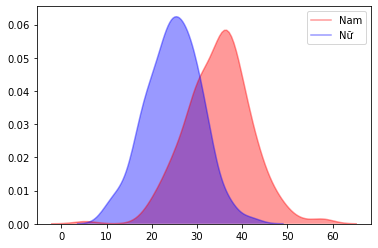

In [7]:
sns.kdeplot(Y_train[X_train.Sex_M == 1], shade = True, 
            color = 'red',  
            alpha = 0.4, 
            label = 'Nam')

sns.kdeplot(Y_train[X_train.Sex_M == 0], 
            shade = True, 
            color = 'blue',  
            alpha = 0.4, 
            label = 'Nữ')

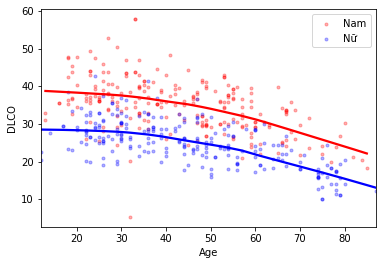

In [8]:
sns.regplot(x=X_train.Age[X_train.Sex_M == 1],
            y=Y_train[X_train.Sex_M == 1],
            lowess = True, 
            marker = ".",
            color = 'red',
            label = 'Nam',
            scatter_kws={'alpha':0.3, 'color':'red'},)

sns.regplot(x=X_train.Age[X_train.Sex_M == 0],
            y=Y_train[X_train.Sex_M == 0],
            lowess = True, marker = ".",
            color = 'blue',
            label = 'Nữ',
            scatter_kws={'alpha':0.3, 'color':'blue'},)

plt.legend()

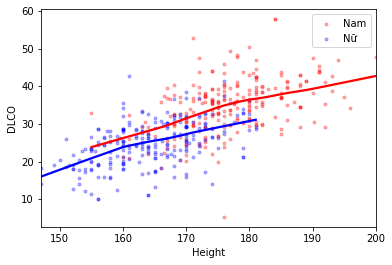

In [9]:
sns.regplot(x=X_train.Height[X_train.Sex_M == 1],
            y=Y_train[X_train.Sex_M == 1],
            lowess = True, 
            marker = ".",
            color = 'red',
            label = 'Nam',
            scatter_kws={'alpha':0.3, 'color':'red'},)

sns.regplot(x=X_train.Height[X_train.Sex_M == 0],
            y=Y_train[X_train.Sex_M == 0],
            lowess = True, marker = ".",
            color = 'blue',
            label = 'Nữ',
            scatter_kws={'alpha':0.3, 'color':'blue'},)

plt.legend()

# Phân phối Gamma trong tensorflow probability

Gamma là 1 phân phối với hình dạng thay đổi linh hoạt từ đối xứng cho đến lệch phải, do đó rất phù hợp để ước lượng những đại lượng sinh học với thang đo là số dương.

Phân bố Gamma được xác định bằng 2 tham số concentration (alpha) và rate (beta),

Cho một biến ngẫu nhiên X có giá trị dương, với giả định x = Gamma(alpha, beta), 
hàm PDF của X có nội dung:

pdf(x; alpha, beta, x > 0) = x**(alpha - 1) exp(-x beta) / Z

với Z = Gamma(alpha) beta**(-alpha)

Thí nghiệm mô phỏng sau cho biết ảnh hưởng riêng biệt của alpha và beta đối với hình dạng phân bố của x:

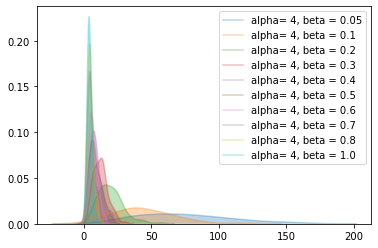

In [10]:
for beta in [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0]:
    concentration = tf.constant(4.0)
    rate = tf.constant(beta)
    dist = tfd.Gamma(concentration, rate)
    samples = dist.sample(100).numpy()
    
    sns.kdeplot(pd.Series(samples, name = str(f'alpha= 4, beta = {beta}')), 
                shade = True, alpha = 0.3)

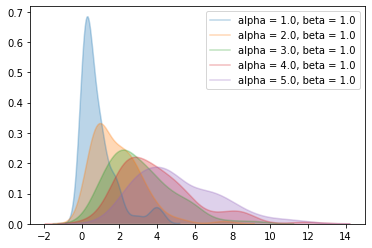

In [11]:
for alpha in [1.0,2.0,3.0,4.0,5.0]:
    concentration = tf.constant(alpha)
    rate = tf.constant(1.0)
    dist = tfd.Gamma(concentration, rate)
    samples = dist.sample(100).numpy()
    
    sns.kdeplot(pd.Series(samples, name = str(f'alpha = {alpha}, beta = 1.0')), shade = True, alpha = 0.3)

# Mô hình Deep learning probabilistic Gamma

Ta sẽ xây dựng một mạng Deep neural network với cấu trúc Sequential như sau:

1) Input layer gồm 3 neurons, tiếp nhận 2D tensor (batch size x 3 features là Height, Weight và Sex_M)

2) 1 hidden layer với 64 neurons

3) Output là một probabilistic layer sử dụng phân bố Gamma

Mục tiêu huấn luyện là giảm tối thiểu giá trị của hàm negative log-likelihood của phân bố Gamma, để xác định giá trị tối ưu của 2 tham số alpha và beta 

Như vậy output của mô hình không phải là 1 kết quả xác định (deterministic), nhưng là giá trị ngẫu nhiên (probabilistic), tuân theo quy luật phân phối Gamma(alpha, beta)

In [12]:
def history_plot(hist = None):
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['loss'],'r-', label='Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [81]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Xây dựng layer phân phối hậu nghiệm posterior với `kernel` và `bias`.trainable

def posterior_mean_field(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Gamma(concentration = tf.nn.softplus(t[..., :n]),
                    rate = 1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Xây dựng layer giả thuyết tiền nghiệm (prior), với `kernel` và `bias`.trainable

def prior_trainable(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Gamma(concentration = tf.nn.softplus(t),
                     rate = 0.01),
          reinterpreted_batch_ndims=1)),
  ])

# Dựng mô hình

model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/X_train.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Gamma(concentration = tf.math.softplus(t[..., :1]),
                          rate = 1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Đóng gói
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)

Huấn luyện mô hình 

In [82]:
early_stop = EarlyStopping(monitor='loss', 
                           min_delta = 0,
                           mode = 'min',
                           patience = 100)

hist = model.fit(X_train.values,Y_train.values,
                 epochs=1000,
                 callbacks=[early_stop],
                 verbose=1)

Train on 477 samples
Epoch 1/1000
477/477 [==============================] - 1s 2ms/sample - loss: 95.7640
Epoch 2/1000
477/477 [==============================] - 0s 142us/sample - loss: 105.8909
Epoch 3/1000
477/477 [==============================] - 0s 159us/sample - loss: 151.4187
Epoch 4/1000
477/477 [==============================] - 0s 143us/sample - loss: 69.7150
Epoch 5/1000
477/477 [==============================] - 0s 130us/sample - loss: 151.0220
Epoch 6/1000
477/477 [==============================] - 0s 141us/sample - loss: 55.4571
Epoch 7/1000
477/477 [==============================] - 0s 129us/sample - loss: 79.1880
Epoch 8/1000
477/477 [==============================] - 0s 133us/sample - loss: 88.5878
Epoch 9/1000
477/477 [==============================] - 0s 139us/sample - loss: 46.2461
Epoch 10/1000
477/477 [==============================] - 0s 136us/sample - loss: 47.7563
Epoch 11/1000
477/477 [==============================] - 0s 138us/sample - loss: 64.0962
Epoch 12

Epoch 93/1000
477/477 [==============================] - 0s 147us/sample - loss: 15.3994
Epoch 94/1000
477/477 [==============================] - 0s 126us/sample - loss: 6.6148
Epoch 95/1000
477/477 [==============================] - 0s 125us/sample - loss: 9.6008
Epoch 96/1000
477/477 [==============================] - 0s 147us/sample - loss: 24.3325
Epoch 97/1000
477/477 [==============================] - 0s 124us/sample - loss: 15.0577
Epoch 98/1000
477/477 [==============================] - 0s 126us/sample - loss: 8.6700
Epoch 99/1000
477/477 [==============================] - 0s 135us/sample - loss: 8.5613
Epoch 100/1000
477/477 [==============================] - 0s 131us/sample - loss: 9.3429
Epoch 101/1000
477/477 [==============================] - 0s 148us/sample - loss: 15.2520
Epoch 102/1000
477/477 [==============================] - 0s 144us/sample - loss: 30.4755
Epoch 103/1000
477/477 [==============================] - 0s 138us/sample - loss: 7.0524
Epoch 104/1000
477/477 

477/477 [==============================] - 0s 140us/sample - loss: 12.4087
Epoch 185/1000
477/477 [==============================] - 0s 142us/sample - loss: 7.8808
Epoch 186/1000
477/477 [==============================] - 0s 153us/sample - loss: 12.3805
Epoch 187/1000
477/477 [==============================] - 0s 142us/sample - loss: 7.5701
Epoch 188/1000
477/477 [==============================] - 0s 110us/sample - loss: 7.9567
Epoch 189/1000
477/477 [==============================] - 0s 125us/sample - loss: 4.9570
Epoch 190/1000
477/477 [==============================] - 0s 154us/sample - loss: 10.8811
Epoch 191/1000
477/477 [==============================] - 0s 128us/sample - loss: 5.7861
Epoch 192/1000
477/477 [==============================] - 0s 129us/sample - loss: 5.0074
Epoch 193/1000
477/477 [==============================] - 0s 127us/sample - loss: 10.0683
Epoch 194/1000
477/477 [==============================] - 0s 141us/sample - loss: 9.1967
Epoch 195/1000
477/477 [========

477/477 [==============================] - 0s 110us/sample - loss: 7.2532
Epoch 277/1000
477/477 [==============================] - 0s 152us/sample - loss: 5.5418
Epoch 278/1000
477/477 [==============================] - 0s 146us/sample - loss: 7.1617
Epoch 279/1000
477/477 [==============================] - 0s 135us/sample - loss: 4.3912
Epoch 280/1000
477/477 [==============================] - 0s 143us/sample - loss: 5.9057
Epoch 281/1000
477/477 [==============================] - 0s 116us/sample - loss: 5.8224
Epoch 282/1000
477/477 [==============================] - 0s 105us/sample - loss: 5.9822
Epoch 283/1000
477/477 [==============================] - 0s 105us/sample - loss: 4.7821
Epoch 284/1000
477/477 [==============================] - 0s 126us/sample - loss: 6.6423
Epoch 285/1000
477/477 [==============================] - 0s 136us/sample - loss: 4.3385
Epoch 286/1000
477/477 [==============================] - 0s 113us/sample - loss: 4.9882
Epoch 287/1000
477/477 [============

477/477 [==============================] - 0s 144us/sample - loss: 4.1190
Epoch 369/1000
477/477 [==============================] - 0s 146us/sample - loss: 4.4605
Epoch 370/1000
477/477 [==============================] - 0s 146us/sample - loss: 4.8866
Epoch 371/1000
477/477 [==============================] - 0s 136us/sample - loss: 5.9069
Epoch 372/1000
477/477 [==============================] - 0s 112us/sample - loss: 5.1326
Epoch 373/1000
477/477 [==============================] - 0s 146us/sample - loss: 5.0118
Epoch 374/1000
477/477 [==============================] - 0s 125us/sample - loss: 5.2560
Epoch 375/1000
477/477 [==============================] - 0s 125us/sample - loss: 4.2753
Epoch 376/1000
477/477 [==============================] - 0s 126us/sample - loss: 4.5615
Epoch 377/1000
477/477 [==============================] - 0s 136us/sample - loss: 4.4237
Epoch 378/1000
477/477 [==============================] - 0s 107us/sample - loss: 4.5409
Epoch 379/1000
477/477 [============

477/477 [==============================] - 0s 126us/sample - loss: 4.4711
Epoch 461/1000
477/477 [==============================] - 0s 129us/sample - loss: 4.8127
Epoch 462/1000
477/477 [==============================] - 0s 136us/sample - loss: 4.5231
Epoch 463/1000
477/477 [==============================] - 0s 167us/sample - loss: 3.9476
Epoch 464/1000
477/477 [==============================] - 0s 151us/sample - loss: 4.3280
Epoch 465/1000
477/477 [==============================] - 0s 134us/sample - loss: 4.1935
Epoch 466/1000
477/477 [==============================] - 0s 115us/sample - loss: 4.1655
Epoch 467/1000
477/477 [==============================] - 0s 126us/sample - loss: 4.5331
Epoch 468/1000
477/477 [==============================] - 0s 105us/sample - loss: 4.3507
Epoch 469/1000
477/477 [==============================] - 0s 125us/sample - loss: 4.8075
Epoch 470/1000
477/477 [==============================] - 0s 129us/sample - loss: 4.4711
Epoch 471/1000
477/477 [============

477/477 [==============================] - 0s 116us/sample - loss: 4.3701
Epoch 553/1000
477/477 [==============================] - 0s 124us/sample - loss: 4.2984
Epoch 554/1000
477/477 [==============================] - 0s 104us/sample - loss: 7.5703
Epoch 555/1000
477/477 [==============================] - 0s 125us/sample - loss: 4.4557
Epoch 556/1000
477/477 [==============================] - 0s 144us/sample - loss: 4.3125
Epoch 557/1000
477/477 [==============================] - 0s 106us/sample - loss: 4.9408
Epoch 558/1000
477/477 [==============================] - 0s 146us/sample - loss: 4.7736
Epoch 559/1000
477/477 [==============================] - 0s 127us/sample - loss: 4.3766
Epoch 560/1000
477/477 [==============================] - 0s 135us/sample - loss: 4.4848
Epoch 561/1000
477/477 [==============================] - 0s 115us/sample - loss: 4.0204
Epoch 562/1000
477/477 [==============================] - 0s 125us/sample - loss: 3.9612
Epoch 563/1000
477/477 [============

477/477 [==============================] - 0s 114us/sample - loss: 4.5346
Epoch 645/1000
477/477 [==============================] - 0s 128us/sample - loss: 4.2023
Epoch 646/1000
477/477 [==============================] - 0s 109us/sample - loss: 4.0568
Epoch 647/1000
477/477 [==============================] - 0s 146us/sample - loss: 3.8537
Epoch 648/1000
477/477 [==============================] - 0s 138us/sample - loss: 3.7675
Epoch 649/1000
477/477 [==============================] - 0s 133us/sample - loss: 4.7492
Epoch 650/1000
477/477 [==============================] - 0s 119us/sample - loss: 3.9879
Epoch 651/1000
477/477 [==============================] - 0s 133us/sample - loss: 4.0004
Epoch 652/1000
477/477 [==============================] - 0s 116us/sample - loss: 4.1723
Epoch 653/1000
477/477 [==============================] - 0s 105us/sample - loss: 3.9730
Epoch 654/1000
477/477 [==============================] - 0s 126us/sample - loss: 3.7598
Epoch 655/1000
477/477 [============

Xem cấu trúc mô hình

In [83]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_19 (DenseV multiple                  24        
_________________________________________________________________
distribution_lambda_19 (Dist multiple                  0         
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


Training curve

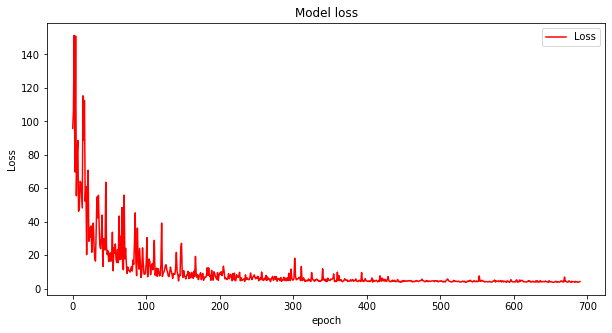

In [84]:
history_plot(hist)

Sao lưu kết quả

In [85]:
# Lưu checkpoint (phiên bản model)

model.save_weights('./saved/checkpoints')

Kiểm định mô hình trên testset: metric = Median error

In [86]:
me = np.array([])

for i in range(100):
    me = np.append(me, medae(Y_test.values, model.predict(X_test.values).flatten()))

In [87]:
pd.Series(me).describe()

count    100.000000
mean       7.726537
std        1.086694
min        5.682620
25%        6.886898
50%        7.658450
75%        8.401652
max       10.458898
dtype: float64

# Sử dụng mô hình trên train set
Sau khi huấn luyện, ta thử áp dụng mô hình để predict train set

Lưu ý rằng output của mô hình không phải là 1 giá trị xác định nhưng ngẫu nhiên, do đó mỗi lần predict, mô hình sẽ cho ra 1 kết quả khác nhau.

Sau đây là hình ảnh của 50 lượt predict trên cùng train-set, ta sẽ có 50 phân bố khác nhau của DLCO trong tập trainset, tuy nhiên chúng khá tương đồng với ít sai biệt

[Text(0, 0.5, 'Predicted DLCO'), Text(0.5, 0, 'Age')]

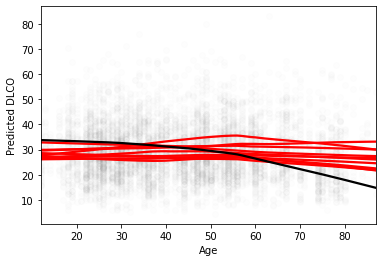

In [88]:
for i in range(10):
    pi = model.predict(X_train.values).flatten()
    g = sns.regplot(X_train.values[:,0], pi, lowess = True,
                    color = 'red',
                scatter_kws={'alpha':0.01, 'color':'grey'},)
    
g = sns.regplot(X_train.values[:,0], Y_train.values, lowess = True, 
                color = 'black',
                scatter_kws={'alpha':0.01, 'color':'grey'},)

g.set(ylabel='Predicted DLCO', xlabel='Age')

[Text(0, 0.5, 'Predicted DLCO'), Text(0.5, 0, 'Height')]

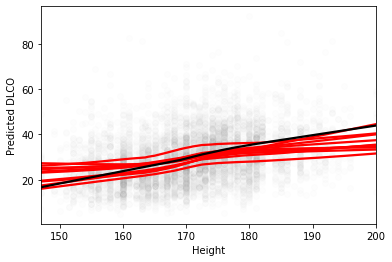

In [89]:
for i in range(10):
    pi = model.predict(X_train.values).flatten()
    g = sns.regplot(X_train.values[:,1], pi, lowess = True, 
                    color = 'red',
                scatter_kws={'alpha':0.01, 'color':'grey'},)
    
g = sns.regplot(X_train.values[:,1], Y_train.values, lowess = True, 
                color = 'black',
                scatter_kws={'alpha':0.01, 'color':'grey'},)

g.set(ylabel='Predicted DLCO', xlabel='Height')

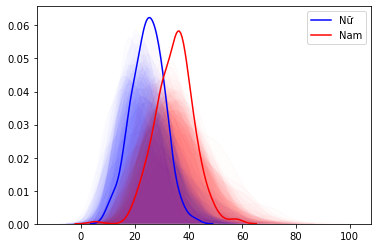

In [90]:
for i in range(50):
    pi = model.predict(X_train.values[X_train['Sex_M'] == 1]).flatten()
    sns.kdeplot(pi,
                shade = True,
                color = 'red',
                alpha = 0.01)
    
    pi = model.predict(X_train.values[X_train['Sex_M'] != 1]).flatten()
    sns.kdeplot(pi,
                shade = True, 
                color = 'blue',
                alpha = 0.01)
    
sns.kdeplot(Y_train.values[X_train['Sex_M'] != 1],
            label = 'Nữ',
            color = 'blue')

sns.kdeplot(Y_train[X_train['Sex_M'] == 1],
            label = 'Nam',
            color = 'red')

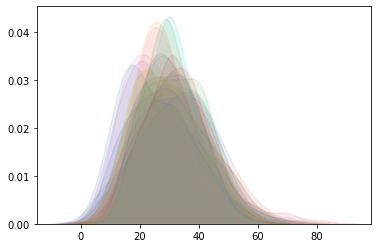

In [91]:
for i in range(20):
    pi = model.predict(X_test.values).flatten()
    sns.kdeplot(pi,
                shade = True, 
                alpha = 0.1)

# Sử dụng mô hình trên test set

Bây giờ ta thử áp dụng mô hình để predict test set

Sau đây là hình ảnh của 50 lượt predict trên cùng test-set, ta sẽ có 50 phân bố khác nhau của DLCO trong tập testset, tuy nhiên chúng khá tương đồng với ít sai biệt

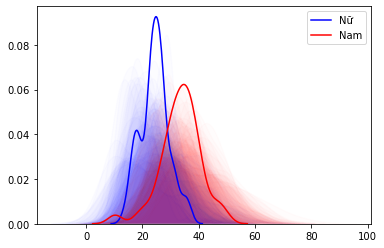

In [99]:
for i in range(50):
    pi = model.predict(X_test.values[X_test['Sex_M'] == 1]).flatten()
    sns.kdeplot(pi,
                shade = True,
                color = 'red',
                alpha = 0.01)
    
    pi = model.predict(X_test.values[X_test['Sex_M'] != 1]).flatten()
    sns.kdeplot(pi,
                shade = True, 
                color = 'blue',
                alpha = 0.01)
    
sns.kdeplot(Y_test.values[X_test['Sex_M'] != 1],
            label = 'Nữ',
            color = 'blue')

sns.kdeplot(Y_test[X_test['Sex_M'] == 1],
            label = 'Nam',
            color = 'red')

Tương tự, ta có thể vẽ 10 đồ thị khác nhau mô tả liên hệ giữa giá trị DLCo dự báo và Tuổi: 

[Text(0, 0.5, 'Predicted DLCO'), Text(0.5, 0, 'Age')]

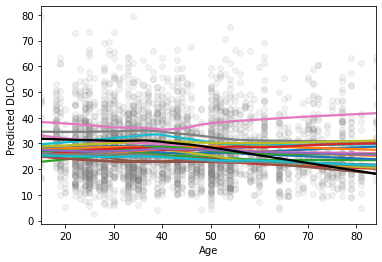

In [93]:
for i in range(20):
    pi = model.predict(X_test.values).flatten()
    g = sns.regplot(X_test.values[:,0], pi, lowess = True, 
                scatter_kws={'alpha':0.1, 'color':'grey'},)

g = sns.regplot(X_test.values[:,0], Y_test.values, lowess = True, 
                color = 'black',
                scatter_kws={'alpha':0.01, 'color':'grey'},)

g.set(ylabel='Predicted DLCO', xlabel='Age')

Ý nghĩa lâm sàng của mô hình đó là khi áp dụng mô hình cho từng cá thể bệnh nhân và lặp lại rất nhiều (N) lần, ta sẽ ước lượng được 1 phân phối của giá trị DLCO bình thường của một quần thể giả định gồm N cá thể có cùng tuổi, chiều cao, cân nặng và giới tính. Thậm chí ta có thể nhìn thấy hình ảnh phân phối này, và định vị được các bách phân vị:

In [94]:
# Case thứ 100 trong tập test-set có DLCO thực tế = 38

Y_test.values[100]

38.0

In [96]:
# Áp dụng 100 lần prediction cho case thứ 2 này

p = np.array([])

for i in range(1000):
    pi = np.array([float(model.predict(X_test.values[100].reshape(1,3)))])
    p = np.append(p, pi)

Đây là hình ảnh phân bố của DLCO cho quần thể giả định gồm 1000 người có cùng đặc tính features như case thứ 2 này:

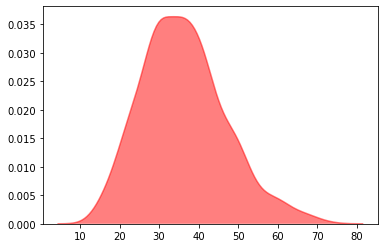

In [97]:
sns.kdeplot(p, shade = True, color = 'red', alpha = 0.5)

Thống kê mô tả cho thấy bách phân vị thứ 5 = 20.438, đây có thể xem là ngưỡng dưới của giá trị bình thường.

Nếu kết quả DLCO thực tế của bệnh nhân thấp hơn 20.438, ta có thể kết luận DLCO của người đó bị giảm bất thường.

In [98]:
pd.Series(p).describe(percentiles = [0.025,0.05,0.1,0.5])

count    1000.000000
mean       36.232601
std        10.651314
min        12.671758
2.5%       18.008119
5%         20.438182
10%        22.985208
50%        35.434237
max        73.283180
dtype: float64

Bài thực hành đến đây là hết, xin tạm biệt các bạn và hẹn gặp lại :)